In [1]:
%load_ext lab_black

In [2]:
import pickle
from pathlib import Path
from typing import Union, Dict, Optional
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from camelsml.metrics import calc_nse

In [3]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str], k, model_type: str, seed: int, epoch: int = 30
) -> Dict:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    return full_results

In [4]:
def parse_results(folder: Union[str, Path], k: int = 5) -> Dict:
    folder = Path(folder)
    results = []
    for i in range(k):
        file = folder / f"{i}" / "i_list.pickle"
        with open(file, "rb") as infile:
            results.append(pickle.load(infile))
    return results


def calc_i(
    permutations: Dict,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
) -> pd.DataFrame:
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    for i in range(k):
        fold = permutations[i]
        features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                for basin in feature_results[k_].keys():
                    feature_results[k_][basin]
                    means[feature][basin] += feature_results[k_][basin] / len(
                        list(feature_results.keys())
                    )
    for feature in features:
        for basin in means[feature].keys():
            if nse_values[basin] >= min_nse:
                means[feature][basin] = nse_values[basin] - means[feature][basin]
            else:
                means[feature][basin] = np.nan
    return pd.DataFrame.from_dict(means).dropna()

In [7]:
k = 5
permutations = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/permutation/",
    k=k,
)
nse_values = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
)
importance_all_features = calc_i(permutations, nse_values, k=k, min_nse=0.7)

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


In [356]:
print(importance_all_features.idxmin())
nse_values["epoch_30"]["39036"]

gauge_easting     54024
gauge_northing    54024
gauge_elev        54024
area              54024
elev_min          54024
                  ...  
frac_mod_perc     54024
frac_low_perc     54024
no_gw_perc        54024
low_nsig_perc     54024
nsig_low_perc     54024
Length: 76, dtype: object


KeyError: '39036'

In [8]:
def importance_metrics(importances: pd.DataFrame, limit: float = 0.1) -> pd.DataFrame:
    fracs = defaultdict(dict)
    for feature in importances.columns:
        fracs[feature][f"Amount i > {limit}"] = (importances[feature] > limit).sum()
        fracs[feature][f"Fraction i > {limit}"] = fracs[feature][
            f"Amount i > {limit}"
        ] / len(importances[feature])
        fracs[feature][f"Max"] = importances[feature].max()
        fracs[feature][
            "|i|"
        ] = f"{importances[feature].mean():.4f}+-{importances[feature].std():.2f}"
        fracs[feature][f"median(i)"] = np.median(importances[feature])
    df = pd.DataFrame.from_dict(fracs).T.sort_values(
        f"Fraction i > {limit}", ascending=False
    )
    return df


fracs_all_features = importance_metrics(importance_all_features, limit=0.1)
fracs_all_features

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
Q95,237,0.571084,1480.16,5.7948+-73.46,0.12938
baseflow_index_ceh,208,0.501205,11.106,0.3113+-0.98,0.100362
p_mean,161,0.387952,2.93657,0.1362+-0.24,0.0690379
Q5,104,0.250602,12.309,0.2297+-0.94,0.0232461
aridity,72,0.173494,1.08625,0.0567+-0.11,0.0262626
...,...,...,...,...,...
low_nsig_perc,15,0.0361446,0.782818,0.0173+-0.06,0.00530059
nsig_low_perc,15,0.0361446,0.782818,0.0175+-0.06,0.00492824
crop_perc,14,0.0337349,0.835114,0.0212+-0.07,0.00775384
porosity_hypres_5,13,0.0313253,1.10888,0.0211+-0.08,0.00622015


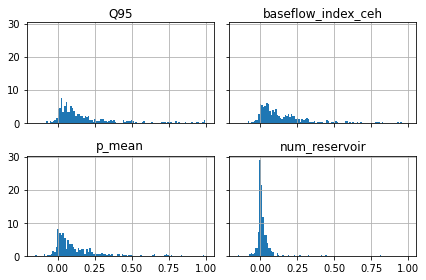

In [9]:
def plot_importances(
    importances: pd.DataFrame, feature: str, ax: Optional[plt.Axes] = None
):
    importances[feature][importances[feature] <= 1].hist(bins=100, density=True, ax=ax)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

features = ["Q95", "baseflow_index_ceh", "p_mean", "num_reservoir"]

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    axes[i].set_title(feature)
fig.tight_layout()
plt.show()

## The above results seem to imply that the EA-LSTM model likes extra precipitation info.
Possibly because the timeseries do not contain enough information? Or maybe sequence_length should be increased?

## The results below indicate that not many basins care about the "physical" features
This is model dependent, will do the same analysis of the reduced model to see if this is still the case

In [10]:
chosen_features = np.genfromtxt(
    "../runs/correlation_reduction/chosen_features/use_features.txt", dtype="str"
)
# BUG!!
chosen_features = chosen_features[
    np.logical_and(chosen_features != "dpsbar", chosen_features != "dom_land_cover")
]
fracs_all_features.loc[chosen_features, :].sort_values(
    "Amount i > 0.1", ascending=False
)

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
area,50,0.120482,0.833907,0.0367+-0.08,0.0148686
elev_50,44,0.106024,0.73686,0.0353+-0.09,0.00945725
elev_10,39,0.0939759,1.17161,0.0371+-0.11,0.00992119
inwater_perc,34,0.0819277,0.439951,0.0301+-0.06,0.0130615
urban_perc,33,0.0795181,1.63305,0.0360+-0.12,0.00950176
conductivity_hypres,33,0.0795181,0.655942,0.0252+-0.07,0.00767327
dwood_perc,27,0.0650602,1.20341,0.0314+-0.10,0.00949244
elev_90,26,0.0626506,0.71461,0.0295+-0.08,0.0106345
ewood_perc,26,0.0626506,0.697971,0.0238+-0.07,0.00661051
root_depth,26,0.0626506,0.959221,0.0255+-0.08,0.00730795


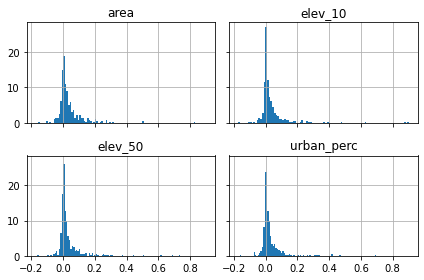

In [11]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

features = ["area", "elev_10", "elev_50", "urban_perc"]

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    axes[i].set_title(feature)
fig.tight_layout()
plt.show()